# Наивный Байес и спам
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW10] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
import random
import re
from collections import Counter
from string import punctuation
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from nltk import SnowballStemmer
from sklearn.model_selection import train_test_split

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=str), np.array(y, dtype=str)

In [4]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_size=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [5]:
X, y = read_dataset("spam")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=SEED)

In [7]:
for x_, y_ in zip(X_train[:5], y_train[:5]):
    print(f"{y_}: {x_}")

ham: Amazing : If you rearrange these letters it gives the same meaning... Dormitory = Dirty room Astronomer = Moon starer The eyes = They see Election results = Lies lets recount Mother-in-law = Woman Hitler Eleven plus two =Twelve plus one Its Amazing... !:-)
ham: Reverse is cheating. That is not mathematics.
ham: Hanging out with my brother and his family
ham: Thanks a lot for your wishes on my birthday. Thanks you for making my birthday truly memorable.
spam: Check Out Choose Your Babe Videos @ sms.shsex.netUN fgkslpoPW fgkslpo


### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [8]:
class NaiveBayes:

    _classes = None         # [n classes]
    _classes_count = None   # int
    _vocab_size = None      # int
    _log_p_y = None         # [n classes]
    _log_p_x_y = None       # { int: [vocab size] }

    def __init__(self, alpha: float):
        """
        Parameters
        ----------
        alpha : float
            Параметр аддитивной регуляризации.
        """
        self.alpha = alpha
    
    def fit(self, sentences: np.ndarray, targets: np.ndarray):
        """
        Оценивает параметры распределения p(x|y) для каждого y.

        m_features: [n sentences; vocab size] -- bag of words for each sentence
        targets: [n sentences] -- sentence targets
        """
        self._classes, self._classes_count = np.unique(targets, return_counts=True)

        _, self._vocab_size = sentences.shape
        self._log_p_x_y = {}
        for cl, cl_counts in zip(self._classes, self._classes_count):
            cl_mask = targets == cl
            word_counts = np.sum(sentences[cl_mask], axis=0)
            total_words = word_counts.sum()
            self._log_p_x_y[cl] = np.log((word_counts + self.alpha) / (total_words + self.alpha * self._vocab_size))

        self._log_p_y = np.log(self._classes_count / self._classes_count.sum())
        
    def predict(self, sentences: np.ndarray) -> list:
        """
        Return
        ------
        list
            Предсказанный класс для каждого элемента из набора X.
        """
        log_probes = self.log_probes(sentences)     # [n sentences; n classes]
        class_idx = np.argmax(log_probes, axis=1)   # [n sentences]
        return self._classes[class_idx]
    
    def log_probes(self, sentences: np.ndarray) -> np.ndarray:
        """
        Return
        ------
        np.ndarray
            Для каждого элемента набора X - логарифм вероятности отнести его к каждому классу. 
            Матрица размера (X.shape[0], n_classes)
        """
        if self._vocab_size is None:
            raise RuntimeError("Fit classifier before predicting something")
        n_sentences, vocab_size = sentences.shape
        if vocab_size != self._vocab_size:
            raise RuntimeError(f"Unexpected size of vocabulary, expected {self._vocab_size}, actual {vocab_size}")

        log_probes = np.zeros((sentences.shape[0], len(self._classes)), dtype=np.float32)
        log_probes += self._log_p_y

        for i, cl in enumerate(self._classes):
            words_probes = np.multiply(sentences, self._log_p_x_y[cl])     # [n sentences; vocab size]
            log_probes[:, i] += np.sum(words_probes, axis=1)

        return log_probes

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [9]:
class BoW:
    def __init__(self, sentences: np.ndarray, voc_size: int = 1000):
        """
        Составляет словарь, который будет использоваться для векторизации предложений.

        Parameters
        ----------
        sentences : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            по которому будет составляться словарь.
        voc_size : int
            Максимальное число слов в словаре.
        """
        self._voc_size = voc_size
        self._words = Counter()
        for sentence in sentences:
            self._words.update(self._tokenize(sentence))
        self._vocabulary = {word: idx for idx, (word, _) in enumerate(self._words.most_common(voc_size))}

    @staticmethod
    def _tokenize(sentence: str) -> List[str]:
        sentence = sentence.lower()
        return sentence.translate(str.maketrans('', '', punctuation)).split()

    def transform(self, sentences: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        sentences : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            который необходимо векторизовать.
        
        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности (n_sentences, vocab_size)
        """
        res = np.zeros((sentences.shape[0], self._voc_size), dtype=np.int32)
        for i, sentence in enumerate(sentences):
            for word in self._tokenize(sentence):
                if word not in self._vocabulary:
                    continue
                else:
                    res[i, self._vocabulary[word]] += 1
        return res

In [10]:
bow = BoW(X_train, voc_size=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [11]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9813278008298755, 'spam': 0.9342105263157895},
 {'ham': 0.9895397489539749, 'spam': 0.8875},
 0.974910394265233)

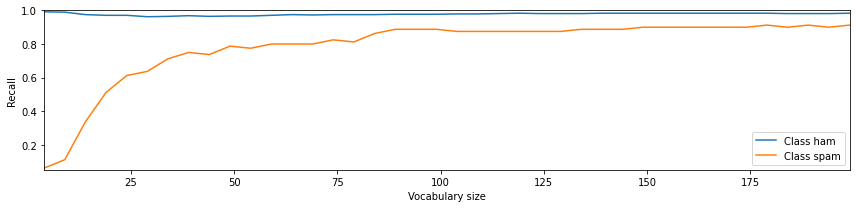

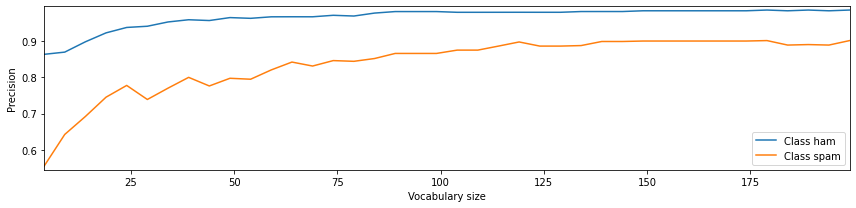

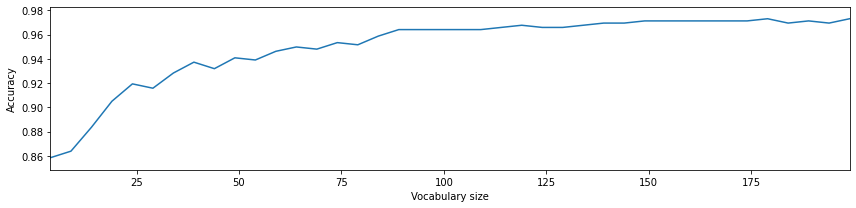

In [12]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [13]:
class BowStem(BoW):
    @staticmethod
    def _tokenize(sentence: str) -> List[str]:
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        words = sentence.translate(str.maketrans('', '', punctuation)).split()
        return [stemmer.stem(word) for word in words]


In [14]:
bows = BowStem(X_train, voc_size=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [15]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.983402489626556, 'spam': 0.9473684210526315},
 {'ham': 0.9916317991631799, 'spam': 0.9},
 0.978494623655914)

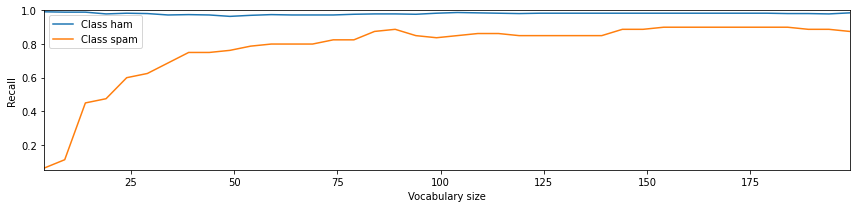

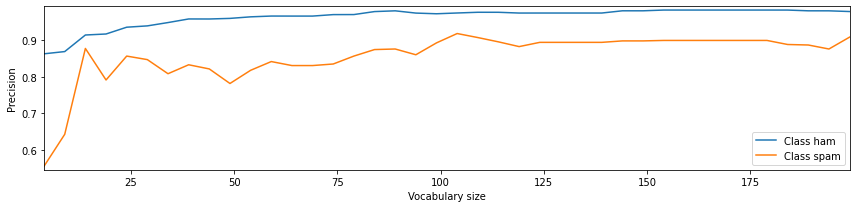

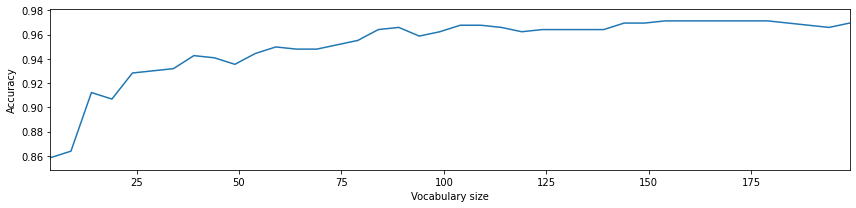

In [16]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)